# Progetto MOBD 2020-2021 - File di Valutazione
## Autori: Andrea Efficace, Lorenzo Rossi


In [1]:
# Package base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pickle
#Splitting dati
import sklearn.model_selection as model_select
#Scoring
import sklearn.metrics as metrics
# Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import (RobustScaler, PolynomialFeatures)
from sklearn.cluster import DBSCAN, OPTICS
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC, LinearSVC
#Cross Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [2]:
class Preprocessing(BaseEstimator):

    def __init__(self, epsilon=6.5, min_samples=10, n_neighbors=2):
        self.epsilon = epsilon
        self.min_samples = min_samples
        self.scanner = DBSCAN(eps=self.epsilon, min_samples=self.min_samples, n_jobs=-1)
        self.upper_bound = 0
        self.lower_bound = 0
        self.n_neighbors = n_neighbors
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors, weights='distance')
        
    #Return DB SCAN
    def get_scanner(self):
        return self.scanner
    #Return self.resample(X,y)
    def fit_resample(self, X, y):
        return self.resample(X, y)
    #Return x,y preprocessed
    def resample(self, X, y):
        x = pd.DataFrame(X)
        y = pd.DataFrame(y)
        # Noise removal
        self.scanner.fit(x)
        noise = x[self.scanner.labels_ == -1].index.values
        x = x.drop(index=noise)
        y = y.drop(index=noise)
        # Outlier removal
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - (1.5 * iqr)
        self.upper_bound = q3 + (1.5 * iqr)
        x.where(~((x < self.lower_bound) | (x > self.upper_bound)), np.nan, inplace=True)
        x = pd.DataFrame(self.imputer.fit_transform(x))
        y_rv = y.values.ravel()
        return x, y_rv

In [3]:
def show_confusion_matrix(cm, f1_score, title):
    """Displays confusion matrix with annotations."""
    # Create annotations label.
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages =\
        ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    box_labels =\
        [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])
    # Show confusion matrix with heat map.
    sns.heatmap(cm,
                annot=box_labels,
                fmt="",
                cmap="YlGnBu",
                cbar=False,
                linewidths=1.0)\
        .set(title=title,
             xlabel='Predicted class\nF1 macro: %0.4f' % f1_score,
             ylabel='Actual class')
    plt.show()

In [4]:
def evaluate_classifier(classifier, data_x, data_y, matrix_title='', show=True):
    """Preprocesses test set and evaluates classifiers."""
    # Rimpiazzo dei valori NaN
    imputer = KNNImputer(n_neighbors=10, weights='distance')
    dati_imputati = imputer.fit_transform(data_x)

    # Dataset senza NaN in forma di Dataframe
    X_imputer = pd.DataFrame(dati_imputati)
    pred_y = classifier.predict(X_imputer)
    confusion_matrix = metrics.confusion_matrix(data_y, pred_y)
    f1_score = metrics.f1_score(data_y, pred_y, average='macro')
    print('\nTest set F1 macro score: %0.4f .\n' % f1_score)
    if show:
        show_confusion_matrix(confusion_matrix, f1_score, matrix_title) 
    return f1_score

In [5]:
def evaluation():
    # Load our classifier.
    with open('bestClassifier.sav', 'rb') as model_file:
        bestClassifier = pickle.load(model_file)
    
    # Load test set.
    testset_path = str(input("Enter test set file name: "))
    testset = pd.read_csv(testset_path)
    print("TEST SET IMPORTED")

    # Separate features and labels.
    x = testset.drop('Label', axis=1)
    y = testset['Label']
    
    evaluate_classifier(bestClassifier, x, y)

TEST SET IMPORTED

Test set F1 macro score: 0.9031 .



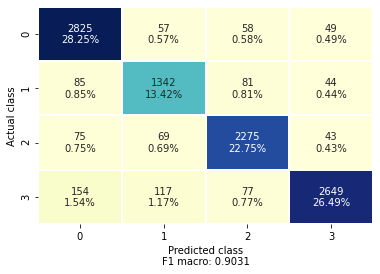

In [6]:
# Start the script.
if __name__ == '__main__':
    evaluation()